In [1]:
import os
import random
import time

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from Physics_Engine import gen

from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
import pygame
import sys


"""
Physics Engine: https://github.com/jaesik817/Interaction-networks_tensorflow/blob/master/physics_engine.py
"""

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


<h2>Generating a dataset: </h2>

In [2]:
num_planets  = 3 
num_node_features = 5 

num_edges  = num_planets * (num_planets - 1) 
num_edge_features = 1


data = gen(num_planets, True, 1000)


class planet:
    def __init__(self, name, mass, pos_x, pos_y):
        # assertions about horizon of experiment
        self.name = name
        self.radius = max(10, int(mass/2.5))
        self.mass = mass
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.color = (random.randrange(0,255), random.randrange(0,255), random.randrange(0,255))
    def get_pos(self, timestamp):
        return (int(self.pos_x[timestamp]), int(self.pos_y[timestamp]))
    
planets = []

for p in range(data.shape[1]):
    mass = data[0][p][0]
    pos_x = data[:,p,1]
    pos_y = data[:,p,2]
    planets.append(planet(chr(ord('a')+p), mass, pos_x, pos_y))

 

<h2>Basic Statistics</h2>

In [3]:

print('Number of Planets:', num_planets)
print('Number of Features:', num_node_features)
print('Dataset shape:', data.shape)

print()
print('Planet weights:', data[0,:,0])

print()
print('Features: [Mass, Pos_X, Pos_Y, Speed_X, Speed_Y]')
print('Features example:',data[10,1,:])

avg_dist = np.mean(np.abs(data[1:999,2,1] - data[0:998,2,1])) + np.mean(np.abs(data[1:999,2,2] - data[0:998,2,2]))
# print('Avg distance between this and the next step:', round(avg_dist,2))

Number of Planets: 3
Number of Features: 5
Dataset shape: (1000, 3, 5)

Planet weights: [100.           0.88755029   1.36809775]

Features: [Mass, Pos_X, Pos_Y, Speed_X, Speed_Y]
Features example: [   0.88755029   -7.82122976   26.12187507 -326.03089553 -185.00317616]


<h2>Visualization</h2>

In [4]:
pygame.init()

screen = pygame.display.set_mode((800,800))

pygame.display.set_caption('Mock Solar System')

fps = pygame.time.Clock()

paused = False


def render(timestep):

    screen.fill((0,0,0))
    
    for planet in planets:
        pos = planet.get_pos(timestep)
        pygame.draw.circle(screen, planet.color, (pos[0]+250, pos[1]+250), planet.radius, 0)

    pygame.display.update()

    fps.tick(60)


timestep = 0


while True:

    pygame.event.get()
        
    if timestep > 500:
        pygame.quit()
        sys.exit
        break


    render(timestep)
    timestep+=1

<h2> Simple NN </h2>

In [5]:
# Data prep

data = gen(num_planets, True, 1000)

train_X = torch.FloatTensor(data[0:800].reshape(800,-1))
test_X = torch.FloatTensor(data[800:-1].reshape(199,-1))

train_y = torch.FloatTensor(data[1:801,:,:2].reshape(800,-1))
test_y = torch.FloatTensor(data[801:,:,:2].reshape(199,-1))


In [6]:
# Define network dimensions
n_input_dim = train_X.shape[1]
# Layer size
n_hidden = 32 
n_output = 6 
learning_rate = 0.005

# Network
net = nn.Sequential(
    nn.Linear(n_input_dim, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, n_output))

loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
print(net)

Sequential(
  (0): Linear(in_features=15, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=6, bias=True)
)


<h2> Train the NN </h2>

In [7]:
train_losses = []
test_losses = []
train_accuracy = []
epochs = 10000
for i in range(epochs):
    data = gen(num_planets, True, 1000)

    train_X = torch.FloatTensor(data[0:800].reshape(800,-1))
    test_X = torch.FloatTensor(data[800:-1].reshape(199,-1))

    train_y = torch.FloatTensor(data[1:801,:,:2].reshape(800,-1))
    test_y = torch.FloatTensor(data[801:,:,:2].reshape(199,-1))
    
    # Train

    y_hat = net(train_X)
    loss = loss_func(y_hat, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # Test
    
    y_hat = net(test_X)
    test_loss = loss_func(y_hat, test_y)
    optimizer.zero_grad()
    
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    
    
    
    print('Epoch:', i, 'Train Loss:', round(loss.item(),3), 'Test Loss', round(test_loss.item(), 3))
# plot loss here

Epoch: 0 Train Loss: 7793.094 Test Loss 5811.763
Epoch: 1 Train Loss: 6041.135 Test Loss 15773.826
Epoch: 2 Train Loss: 3705.868 Test Loss 2736.922
Epoch: 3 Train Loss: 4429.999 Test Loss 155514.109
Epoch: 4 Train Loss: 2364.009 Test Loss 4770.864
Epoch: 5 Train Loss: 2095.146 Test Loss 2070.72
Epoch: 6 Train Loss: 2777.638 Test Loss 2830.441
Epoch: 7 Train Loss: 1730.534 Test Loss 2774.709
Epoch: 8 Train Loss: 2505.218 Test Loss 5561.985
Epoch: 9 Train Loss: 1342.406 Test Loss 1627.805
Epoch: 10 Train Loss: 2074.729 Test Loss 3233.813
Epoch: 11 Train Loss: 1664.329 Test Loss 1019.195
Epoch: 12 Train Loss: 1342.574 Test Loss 805.185
Epoch: 13 Train Loss: 1146.974 Test Loss 1353.334
Epoch: 14 Train Loss: 8614.157 Test Loss 32280.648
Epoch: 15 Train Loss: 139110.297 Test Loss 629237.188
Epoch: 16 Train Loss: 846.44 Test Loss 591.304
Epoch: 17 Train Loss: 237109.562 Test Loss 1268859.0
Epoch: 18 Train Loss: 1825.186 Test Loss 1832.889
Epoch: 19 Train Loss: 1220.128 Test Loss 1210.17
Epoch

KeyboardInterrupt: 

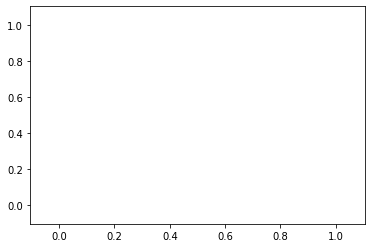

In [8]:
%matplotlib inline

# Plotting the loss


t = range(0,len(train_losses))[100:]
a = train_losses[100:]
b = test_losses[100:]


plt.plot(t, a, 'r') # plotting t, a separately 
plt.plot(t, b, 'b') # plotting t, b separately 
plt.show()

In [9]:
def get_batch(train = True):
    
    batch_size = 99
    
    num_planets  = random.randrange(1,6)
    
    if train:
        num_planets = 3
    
    num_node_features = 5 
    num_edges  = num_planets * (num_planets - 1) 
    num_edge_features = 1


    data = gen(num_planets, True, 100)
    
    X = data[0:99]
    y = data[1:100,:,:2]

    # Helper functions
    edge_list = []

    for i in range(num_planets):
        for j in range(num_planets):
            if i!=j:
                edge_list.append((i,j))
                


    edge_out = np.zeros((batch_size, num_edges, num_planets), dtype=float);
    edge_in = np.zeros((batch_size, num_edges, num_planets), dtype=float);
    edge_features = Variable(torch.FloatTensor(np.zeros((batch_size, num_edges, num_edge_features))))


    row = 0
    for edge in edge_list:
        edge_out[0,row,edge[0]] = 1
        edge_in[0,row,edge[1]] = 1

        row+=1


    edge_out = Variable(torch.FloatTensor(edge_out))
    edge_in = Variable(torch.FloatTensor(edge_in))
         

    data = Variable(torch.FloatTensor(X))
    labels = Variable(torch.FloatTensor(y.reshape(-1,2)))
    
    return data, edge_out, edge_in, edge_features, labels



<h2>Graph Neural Network</h2>

In [10]:
class graph_NN(nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, embedding_dim, output_dim):
        super(graph_NN, self).__init__()
        
        self.edge_NN = nn.Sequential(nn.Linear(2 * num_node_features + num_edge_features, hidden_dim), 
                                     nn.ReLU(), 
                                     nn.Linear(hidden_dim, embedding_dim))
        
        self.node_NN = nn.Sequential(nn.Linear(num_node_features + embedding_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, output_dim),
                                    )
        print('edge_NN:', self.edge_NN)
        print('node_NN:', self.node_NN)
    
    def forward(self, data, edge_out, edge_in, edge_features):
        
        first_vertex_data   = edge_out.bmm(data)
        second_vertex_data = edge_in.bmm(data)
        
        edge_embeddings = self.edge_NN(torch.cat([first_vertex_data, second_vertex_data, edge_features], 2))
        
        aggregated_edge_embeddings = edge_in.permute(0,2,1).bmm(edge_embeddings)
        
        predicted = self.node_NN(torch.cat([data,aggregated_edge_embeddings], 2).view(-1, num_node_features + embedding_dim))
        
        return predicted

In [13]:
n_epoch = 1000
lr = 0.005
hidden_dim = 16
embedding_dim = 8
output_dim = 2
num_node_features = 5
num_edge_features = 1

graph_NN_instance = graph_NN(num_node_features, num_edge_features,  hidden_dim, embedding_dim, output_dim)
optimizer = optim.Adam(graph_NN_instance.parameters(),  lr=lr)
criterion = nn.MSELoss()

edge_NN: Sequential(
  (0): Linear(in_features=11, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=8, bias=True)
)
node_NN: Sequential(
  (0): Linear(in_features=13, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=2, bias=True)
)


In [14]:
losses = []

for epoch in range(n_epoch):
    data, edge_out, edge_in, edge_features, labels = get_batch()
    
    predicted = graph_NN_instance(data, edge_out, edge_in, edge_features)
    
    loss = criterion(predicted, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(np.sqrt(loss.data))
    
    data_test, edge_out, edge_in, edge_features, labels = get_batch(False)    
    predicted = graph_NN_instance(data_test, edge_out, edge_in, edge_features)
    test_loss = criterion(predicted, labels)

    print('Epoch:', epoch, 'Test Loss:', np.sqrt(test_loss.data),'Test Planets:', data_test.shape[1])

        
        


Epoch: 0 Test Loss: tensor(62.3488) Test Planets: 3
Epoch: 1 Test Loss: tensor(70.1196) Test Planets: 1
Epoch: 2 Test Loss: tensor(55.8519) Test Planets: 4
Epoch: 3 Test Loss: tensor(56.4607) Test Planets: 2
Epoch: 4 Test Loss: tensor(69.0262) Test Planets: 1
Epoch: 5 Test Loss: tensor(43.3434) Test Planets: 5
Epoch: 6 Test Loss: tensor(47.4066) Test Planets: 4
Epoch: 7 Test Loss: tensor(68.2051) Test Planets: 1
Epoch: 8 Test Loss: tensor(52.1681) Test Planets: 2
Epoch: 9 Test Loss: tensor(48.9013) Test Planets: 2
Epoch: 10 Test Loss: tensor(42.8500) Test Planets: 5
Epoch: 11 Test Loss: tensor(38.0627) Test Planets: 5
Epoch: 12 Test Loss: tensor(63.1249) Test Planets: 2
Epoch: 13 Test Loss: tensor(39.8755) Test Planets: 3
Epoch: 14 Test Loss: tensor(49.4482) Test Planets: 2
Epoch: 15 Test Loss: tensor(39.5667) Test Planets: 3
Epoch: 16 Test Loss: tensor(40.3749) Test Planets: 4
Epoch: 17 Test Loss: tensor(43.3964) Test Planets: 5
Epoch: 18 Test Loss: tensor(44.4363) Test Planets: 4
Epo

Epoch: 154 Test Loss: tensor(3.7195) Test Planets: 4
Epoch: 155 Test Loss: tensor(5.4650) Test Planets: 3
Epoch: 156 Test Loss: tensor(6.2932) Test Planets: 5
Epoch: 157 Test Loss: tensor(4.0645) Test Planets: 2
Epoch: 158 Test Loss: tensor(6.6825) Test Planets: 5
Epoch: 159 Test Loss: tensor(4.6873) Test Planets: 3
Epoch: 160 Test Loss: tensor(5.4612) Test Planets: 4
Epoch: 161 Test Loss: tensor(5.6612) Test Planets: 4
Epoch: 162 Test Loss: tensor(0.2831) Test Planets: 1
Epoch: 163 Test Loss: tensor(0.2238) Test Planets: 1
Epoch: 164 Test Loss: tensor(4.4593) Test Planets: 4
Epoch: 165 Test Loss: tensor(4.0558) Test Planets: 2
Epoch: 166 Test Loss: tensor(4.2988) Test Planets: 3
Epoch: 167 Test Loss: tensor(0.0374) Test Planets: 1
Epoch: 168 Test Loss: tensor(2.4548) Test Planets: 2
Epoch: 169 Test Loss: tensor(4.1043) Test Planets: 2
Epoch: 170 Test Loss: tensor(4.4539) Test Planets: 2
Epoch: 171 Test Loss: tensor(0.2257) Test Planets: 1
Epoch: 172 Test Loss: tensor(0.2337) Test Plan

Epoch: 308 Test Loss: tensor(0.2706) Test Planets: 1
Epoch: 309 Test Loss: tensor(0.2685) Test Planets: 1
Epoch: 310 Test Loss: tensor(2.2862) Test Planets: 2
Epoch: 311 Test Loss: tensor(0.2811) Test Planets: 1
Epoch: 312 Test Loss: tensor(2.2612) Test Planets: 3
Epoch: 313 Test Loss: tensor(1.4518) Test Planets: 2
Epoch: 314 Test Loss: tensor(2.2579) Test Planets: 5
Epoch: 315 Test Loss: tensor(1.9565) Test Planets: 3
Epoch: 316 Test Loss: tensor(1.9500) Test Planets: 4
Epoch: 317 Test Loss: tensor(2.4750) Test Planets: 4
Epoch: 318 Test Loss: tensor(1.8939) Test Planets: 5
Epoch: 319 Test Loss: tensor(2.4187) Test Planets: 5
Epoch: 320 Test Loss: tensor(2.2624) Test Planets: 4
Epoch: 321 Test Loss: tensor(2.4822) Test Planets: 5
Epoch: 322 Test Loss: tensor(1.5695) Test Planets: 3
Epoch: 323 Test Loss: tensor(1.8852) Test Planets: 2
Epoch: 324 Test Loss: tensor(2.5161) Test Planets: 5
Epoch: 325 Test Loss: tensor(0.1410) Test Planets: 1
Epoch: 326 Test Loss: tensor(0.2099) Test Plan

Epoch: 462 Test Loss: tensor(1.7522) Test Planets: 3
Epoch: 463 Test Loss: tensor(2.2360) Test Planets: 2
Epoch: 464 Test Loss: tensor(0.8343) Test Planets: 4
Epoch: 465 Test Loss: tensor(1.8489) Test Planets: 4
Epoch: 466 Test Loss: tensor(1.3793) Test Planets: 2
Epoch: 467 Test Loss: tensor(0.1251) Test Planets: 1
Epoch: 468 Test Loss: tensor(1.4715) Test Planets: 2
Epoch: 469 Test Loss: tensor(1.6965) Test Planets: 5
Epoch: 470 Test Loss: tensor(1.3736) Test Planets: 5
Epoch: 471 Test Loss: tensor(1.3866) Test Planets: 4
Epoch: 472 Test Loss: tensor(2.4393) Test Planets: 5
Epoch: 473 Test Loss: tensor(1.8294) Test Planets: 4
Epoch: 474 Test Loss: tensor(0.0207) Test Planets: 1
Epoch: 475 Test Loss: tensor(0.9731) Test Planets: 4
Epoch: 476 Test Loss: tensor(1.3974) Test Planets: 3
Epoch: 477 Test Loss: tensor(1.5628) Test Planets: 2
Epoch: 478 Test Loss: tensor(0.8118) Test Planets: 3
Epoch: 479 Test Loss: tensor(3.0108) Test Planets: 5
Epoch: 480 Test Loss: tensor(1.4797) Test Plan

Epoch: 616 Test Loss: tensor(0.6433) Test Planets: 2
Epoch: 617 Test Loss: tensor(1.4072) Test Planets: 4
Epoch: 618 Test Loss: tensor(1.3581) Test Planets: 4
Epoch: 619 Test Loss: tensor(1.4219) Test Planets: 2
Epoch: 620 Test Loss: tensor(0.1722) Test Planets: 1
Epoch: 621 Test Loss: tensor(0.1942) Test Planets: 1
Epoch: 622 Test Loss: tensor(2.2047) Test Planets: 3
Epoch: 623 Test Loss: tensor(0.9296) Test Planets: 2
Epoch: 624 Test Loss: tensor(1.4246) Test Planets: 3
Epoch: 625 Test Loss: tensor(0.2428) Test Planets: 1
Epoch: 626 Test Loss: tensor(1.1668) Test Planets: 4
Epoch: 627 Test Loss: tensor(0.8966) Test Planets: 3
Epoch: 628 Test Loss: tensor(0.6990) Test Planets: 3
Epoch: 629 Test Loss: tensor(1.7636) Test Planets: 3
Epoch: 630 Test Loss: tensor(0.2954) Test Planets: 1
Epoch: 631 Test Loss: tensor(0.2832) Test Planets: 1
Epoch: 632 Test Loss: tensor(1.6447) Test Planets: 3
Epoch: 633 Test Loss: tensor(0.2317) Test Planets: 1
Epoch: 634 Test Loss: tensor(0.2346) Test Plan

Epoch: 770 Test Loss: tensor(1.0637) Test Planets: 2
Epoch: 771 Test Loss: tensor(1.2993) Test Planets: 3
Epoch: 772 Test Loss: tensor(1.9210) Test Planets: 5
Epoch: 773 Test Loss: tensor(1.0633) Test Planets: 2
Epoch: 774 Test Loss: tensor(0.2541) Test Planets: 1
Epoch: 775 Test Loss: tensor(0.7496) Test Planets: 2
Epoch: 776 Test Loss: tensor(1.1604) Test Planets: 3
Epoch: 777 Test Loss: tensor(2.2614) Test Planets: 5
Epoch: 778 Test Loss: tensor(1.7068) Test Planets: 4
Epoch: 779 Test Loss: tensor(0.3044) Test Planets: 1
Epoch: 780 Test Loss: tensor(0.3960) Test Planets: 1
Epoch: 781 Test Loss: tensor(1.4144) Test Planets: 5
Epoch: 782 Test Loss: tensor(2.0788) Test Planets: 3
Epoch: 783 Test Loss: tensor(2.1983) Test Planets: 5
Epoch: 784 Test Loss: tensor(1.8022) Test Planets: 4
Epoch: 785 Test Loss: tensor(1.3499) Test Planets: 2
Epoch: 786 Test Loss: tensor(1.8944) Test Planets: 3
Epoch: 787 Test Loss: tensor(0.1002) Test Planets: 1
Epoch: 788 Test Loss: tensor(0.1171) Test Plan

Epoch: 924 Test Loss: tensor(0.7711) Test Planets: 4
Epoch: 925 Test Loss: tensor(1.2957) Test Planets: 3
Epoch: 926 Test Loss: tensor(1.4898) Test Planets: 3
Epoch: 927 Test Loss: tensor(1.6824) Test Planets: 3
Epoch: 928 Test Loss: tensor(0.2322) Test Planets: 1
Epoch: 929 Test Loss: tensor(2.7496) Test Planets: 5
Epoch: 930 Test Loss: tensor(2.0650) Test Planets: 5
Epoch: 931 Test Loss: tensor(1.5065) Test Planets: 2
Epoch: 932 Test Loss: tensor(0.9070) Test Planets: 3
Epoch: 933 Test Loss: tensor(1.2064) Test Planets: 3
Epoch: 934 Test Loss: tensor(0.2485) Test Planets: 1
Epoch: 935 Test Loss: tensor(0.2433) Test Planets: 2
Epoch: 936 Test Loss: tensor(0.9297) Test Planets: 5
Epoch: 937 Test Loss: tensor(1.7959) Test Planets: 5
Epoch: 938 Test Loss: tensor(1.6357) Test Planets: 5
Epoch: 939 Test Loss: tensor(0.1122) Test Planets: 1
Epoch: 940 Test Loss: tensor(1.0030) Test Planets: 3
Epoch: 941 Test Loss: tensor(0.2134) Test Planets: 1
Epoch: 942 Test Loss: tensor(0.2167) Test Plan